# Module 5: Introduction to Artificial Neural Networks with Keras

In this module, we will study ___artificial neural networks (ANNs)___.  The first part of this module introduces artificial neural networks, starting with a quick tour of the very first ANN architectures and leading up to ___Multilayer Perceptrons (MLPs)___, which are heavily used today. In the second part of this module, we will look at how to implement neural networks using the popular ___Keras API___. Keras is a simple high-level API for building, training, evaluating, and running neural networks.

In [20]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Perceptrons

Scikit-Learn provides a ___Perceptron class___ that implements a single-TLU network. 

**Note**: We set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [21]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
# In the video, Dr. Morabito uses the line y = (iris.target == 0).astype(np.int)
# This is deprecated code. Instead, use y = (iris.target == 0).astype(int)

iris = load_iris()
X = iris.data[:, (2,3)] #petal length, petal width
y = (iris.target == 0 ).astype(np.int64) #Iris setosa

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([1], dtype=int64)

Saving figure perceptron_iris_plot


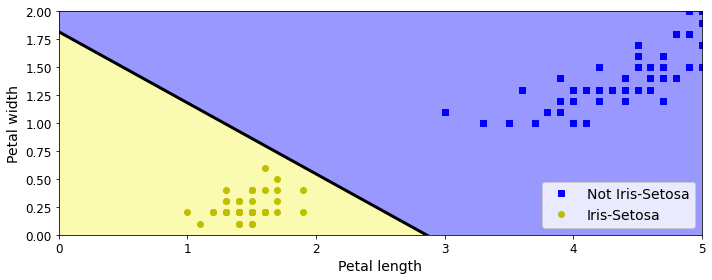

In [22]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# The Multilayer Perceptron

In 1969 Minsky and Papert demostrated a number of serious weaknesses with perceptrons — in particular, that they are incapable of solving some trivial problems such as the Exclusive OR (XOR) classification problem.

It turns out that some of the limitations of perceptrons can be eliminated by stacking multiple perceptrons. The resulting ANN is called a ___Multilayer Perceptron (MLP)___. An MLP can solve the XOR problem.

<img src="Figures/XOR_problem.png" title="XOR_problem" width=600/>

An MLP is composed of one (pass-through) input layer, one or more layers of TLUs, called hidden layers, and one final layer of TLUs called the output layer (see the following figure). The layers close to the input layer are usually called the lower layers, and the ones close to the outputs are usually called the upper layers. Every layer except the output layer includes a bias neuron and is fully connected to the next layer.

When an ANN contains a deep stack of hidden layers, it is called a ___deep neural network (DNN)___.

An MLP with one hidden layer is illustrated below:

<img src="Figures/MLP.png" title="MLP" width=450/>

The signal flows only in one direction, so this architecture is an example of a ___feedforward neural network (FNN)___.

## Backpropogation Training Algorithm

In 1986, the ___backpropagation training algorithm___ was introduced, which is essentially just Gradient Descent using an efficient technique for computing the gradients automatically in just two passes through the network (one forward, one backward).  The backpropagation algorithm is able to compute the gradient of the network’s error with regard to every single model parameter. That is, it can find out how each connection weight and each bias term should be tweaked in order to reduce the error.

Let's look at the backpropogation algorithm in more detail:

- It handles one ___mini-batch___ at a time, and it goes through the full training set multiple times. Each pass is called an ___epoch___.


- Each mini-batch is passed to the network’s input layer, which sends it to the first hidden layer. The algorithm then computes the output of all the neurons in this layer (for every instance in the mini-batch). The result is passed on to the next layer, its output is computed and passed to the next layer, and so on until we get the output of the last layer, the output layer. This is the forward pass: it is exactly like making predictions, except all intermediate results are preserved since they are needed for the backward pass.


- Next, the algorithm measures the network’s output error.


- Then it computes how much each output connection contributed to the error.


- The algorithm then measures how much of these error contributions came from each connection in the layer below, working backward until the algorithm reaches the input layer. As explained earlier, this reverse pass efficiently measures the error gradient across all the connection weights in the network by propagating the error gradient backward through the network.


- Finally, the algorithm performs a Gradient Descent step to tweak all the connection weights in the network, using the error gradients it just computed.

This algorithm is illustrated below ([image source](https://www.researchgate.net/figure/Schematic-diagram-of-backpropagation-training-algorithm-and-typical-neuron-model_fig2_275721804)): 

<img src="Figures/backpropogation.png" title="backpropogation" width=850/>


## Activation Functions

In order for the MLP backpropogation training algorithm to work properly, its authors needed to make a key change to the MLP’s architecture: they replaced the step function with the ___logistic (sigmoid) function___, 

$$ \sigma(z) = \frac{1}{(1 + e^{–z})} $$ 

This was essential because the step function contains only flat segments, so there is no gradient to work with (Gradient Descent cannot move on a flat surface), while the logistic function has a well-defined nonzero derivative everywhere, allowing Gradient Descent to make some progress at every step. In fact, the backpropagation algorithm works well with many other activation functions, not just the logistic function. Here are two other popular choices:

___The Hyperbolic Tangent Function___: 

$$ tanh(z) = 2 \sigma (2z) – 1 $$

___The Rectified Linear Unit Function___: 

$$ ReLU(z) = \max(0, z) $$

In [23]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


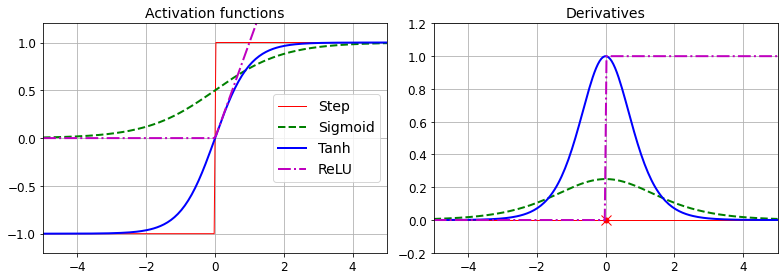

In [24]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

Let's quickly revist the XOR problem and take a look at how stacking MLPs can solve it!

In [25]:
def heaviside(z):
    return (z >=0).astype(z.dtype)


def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

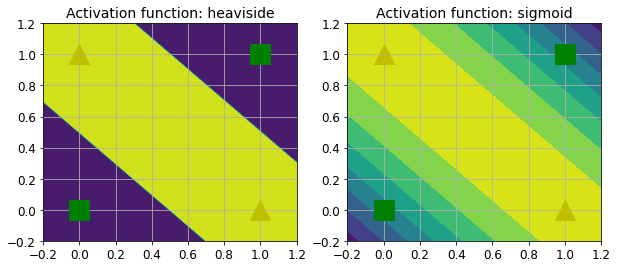

In [26]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Regression MLPs

MLPs can be used for ___regression tasks___. If you want to predict a single value, then you just need a single output neuron: its output is the predicted value. For multivariate regression, you need one output neuron per output dimension.

When building an MLP for regression, you may want to specify an activation function for the output neurons that will output values in a certain range. For example, if you want to guarantee that the output will always be positive, then you can use the ___ReLU activation function___ in the output layer. Alternatively, you can use the ___softplus activation function___, which is a smooth variant of ReLU that is close to 0 when z is negative, and close to z when z is positive:

$$ softplus(z) = \log(1 + e^{z}) $$ 

Finally, if you want to guarantee that the predictions will fall within a given range of values, then you can use the ___logistic function___ or the ___hyperbolic tangent___ activation functions, and then scale the labels to the appropriate range: 0 to 1 for the logistic function and –1 to 1 for the hyperbolic tangent.

The following table summarizes the typical architecture of a regression MLP:

<img src="Figures/regressionMLP.png" title="regressionMLP" width=700/>

# Classification MLPs

MLPs can also be used for ___classification tasks___. For a binary classification problem, you just need a single output neuron using the logistic activation function: the output will be a number between 0 and 1, which you can interpret as the estimated probability of the positive class.

MLPs can also easily handle ___multilabel binary classification___ tasks.  More generally, you would dedicate one output neuron for each positive class. Note that the output probabilities do not necessarily add up to 1.  If each instance can belong only to a single class, out of three or more possible classes (e.g., classes 0 through 9 for digit image classification), then you need to have one output neuron per class, and you should use the softmax activation function for the whole output layer (see the following figure). The ___softmax function___ will ensure that all the estimated probabilities are between 0 and 1 and that they add up to 1 (which is required if the classes are exclusive). This is called ___multiclass classification___.

<img src="Figures/softmax.png" title="softmax" width=500/>

The following table summarizes the typical architecture of a classification MLP:

<img src="Figures/classificationMLP.png" title="classificationMLP" width=700/>

Before we go on, I recommend you go through exercise 1 at the end of chapter 10 in our textbook. You will play with various neural network architectures and visualize their outputs using the [TensorFlow Playground](https://playground.tensorflow.org/). This will be very useful to better understand MLPs, including the effects of all the hyperparameters (number of layers and neurons, activation functions, and more).

# Building an Image Classifier Using the Sequential API

Let's tackle the Fashion MNIST dataset. It has the exact same format as MNIST (70,000 grayscale images of 28 × 28 pixels each, with 10 classes), but the images represent fashion items rather than handwritten digits, so each class is more diverse, and the problem turns out to be significantly more challenging than MNIST.

First let's import TensorFlow and Keras.

In [27]:
import tensorflow as tf
import keras
from keras import layers

In [12]:
tf.__version__

'2.15.0'

In [ ]:
keras.__version__

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [28]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [14]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [15]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [29]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000] / 255.0, y_train_full[5000:] 
X_test = X_test / 255.0 

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

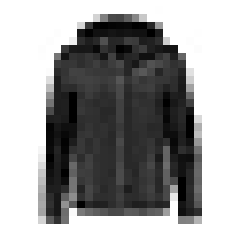

In [30]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [31]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [32]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [33]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [34]:
X_valid.shape

(5000, 28, 28)

In [35]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


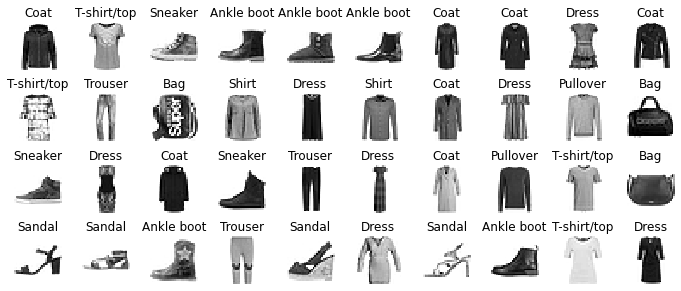

In [36]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

Now let’s build the neural network! Here is a classification MLP with two hidden layers:

In [37]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))


When a layer of nuerons receives some input data, its outputs are computed based on the equation

$$ h_{\bf{W, b}} (\bf{X}) = \phi (\bf{XW} + \bf{b})) $$

where

- As always, $\bf{X}$ represents the feature matrix of inputs. It has one row per instance and one column per feature.


- The weight matrix $\bf{W}$ contains all the connection weights except for the ones from the bias neuron. It has one row per input neuron and one column per artificial neuron in the layer.


- The bias vector $\bf{b}$ contains all the connection weights between the bias neuron and the artificial neurons. It has one bias term per artificial neuron.


- The function $\mathbf{\phi}$ is called the activation function: when the artificial neurons are TLUs, it is a step function.

Check the [full list](https://keras.io/api/layers/activations/) of available activation functions.

Instead of adding the layers one by one as we just did, you can pass a list of layers when creating the Sequential model:

In [38]:
import keras
import tensorflow

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [39]:
model = keras.models.Sequential([
                                keras.layers.Flatten(input_shape=[28,28]),
                                keras.layers.Dense(300, activation="relu"),
                                keras.layers.Dense(100, activation="relu"),
                                keras.layers.Dense(10, activation="softmax"),
                                 ])

In [40]:
model.layers

The model’s `summary()` method displays all the model’s layers, including each layer’s name, its output shape (`None` means the batch size can be anything), and its number of parameters. The summary ends with the total number of parameters, including trainable and non-trainable parameters. Here we only have trainable parameters.

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Note**: You will have to make sure two packages are installed for the following cell to execute. 

In [43]:


keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [44]:
model.layers

In [45]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [46]:
model.get_layer(hidden1.name) is hidden1

True

In [47]:
weights, biases = hidden1.get_weights()

All the parameters of a layer can be accessed using its `get_weights()` and `set_weights()` methods. For a `Dense` layer, this includes both the connection weights and the bias terms:

In [ ]:
weights, biases = hidden1.get_weights()

In [49]:
weights

array([[-0.05218842, -0.01486446, -0.05361078, ...,  0.02258476,
         0.03114338, -0.07423742],
       [ 0.02917989,  0.00751808,  0.02465824, ...,  0.0508467 ,
        -0.06425366, -0.05745995],
       [-0.01649528, -0.01080783,  0.00561649, ..., -0.0300978 ,
        -0.00842088, -0.01804307],
       ...,
       [ 0.06782795,  0.0121202 , -0.0430969 , ...,  0.02056204,
         0.05313757, -0.01076209],
       [-0.05065725,  0.05759323, -0.06703547, ...,  0.02379845,
         0.05631907, -0.06668755],
       [-0.05457311, -0.0189869 , -0.05211867, ...,  0.01716103,
         0.04010307, -0.02009454]], dtype=float32)

In [48]:
weights.shape

(784, 300)

In [50]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [51]:
biases.shape

(300,)

### Compiling the Model

In [52]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer='sgd',
              metrics=['accuracy'])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

### Training and Evaluating the Model

In [54]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4434 - accuracy: 0.8432 - val_loss: 8.0378 - val_accuracy: 0.0636
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4143 - accuracy: 0.8538 - val_loss: 7.4221 - val_accuracy: 0.0764
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3938 - accuracy: 0.8609 - val_loss: 7.4377 - val_accuracy: 0.0744
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3781 - accuracy: 0.8668 - val_loss: 8.0960 - val_accuracy: 0.0770
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3663 - accuracy: 0.8707 - val_loss: 8.0606 - val_accuracy: 0.0736
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3515 - accuracy: 0.8750 - val_loss: 7.6719 - val_accuracy: 0.0830
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3422 - accuracy: 0.8774 - val_loss: 7.8456 - val_accuracy:

In [55]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 1719}

In [56]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
history.history

Saving figure keras_learning_curves_plot


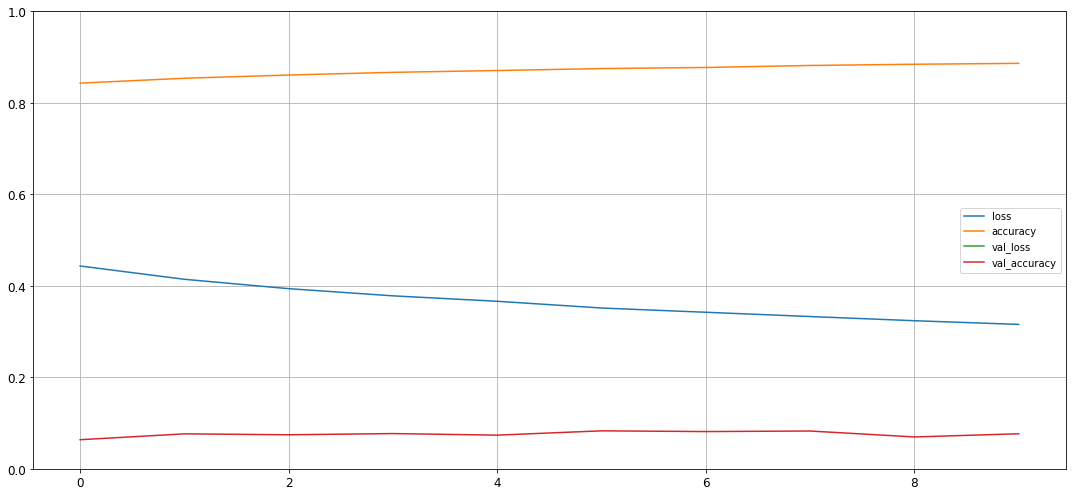

In [57]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(15, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [58]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.3709 - accuracy: 0.8644


[0.37091127038002014, 0.8644000291824341]

### Using the Model to Make Predictions

Next, we can use the model’s `predict()` method to make predictions on new instances. Since we don’t have actual new instances, we will just use the first three instances of the test set:

In [59]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 88ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.05, 0.  , 0.91],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [60]:
# In Dr. Morabito's video, he uses the line <y_pred = model.predict_classes(X_new)>. The predict_classes method is deprecated.
# Instead, use <y_pred = np.argmax(model.predict(X_new), axis=-1)>

y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 20ms/step


array([9, 2, 1], dtype=int64)

In [61]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [62]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


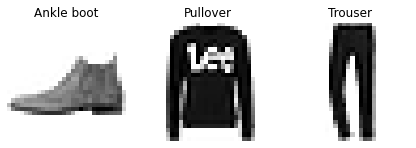

In [63]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Building a Regression MLP Using the Sequential API

Let's perform regression using the California housing price dataset and a neural network built using the Sequential API.  This is the original dataset, and not the modifed version used when studying chapter 2 of our textbook.

In [64]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)



scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [65]:
np.random.seed(42)
tf.random.set_seed(42)

In [66]:
# In Dr. Morabito's video, he uses the optimizer keras.optimizers.SGD(lr=1e-3)
# lr is deprecated code. Instead, use optimizer=keras.optimizers.SGD(learning_rate=1e-3)
# learning_rate is used a few more times in this module. Be sure to use <learning_rate> when Dr. Morabito uses <lr>

model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)

])#build layers
#compile model
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))



Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.1998 - val_loss: 1.1824
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7379 - val_loss: 0.6537
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6602 - val_loss: 0.6083
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6163 - val_loss: 0.5959
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5835 - val_loss: 0.5376
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5529 - val_loss: 0.5288
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5310 - val_loss: 0.4896
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5119 - val_loss: 0.4754
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4957 - val_loss: 0.4697
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4837 - val_loss: 0.4493

In [67]:
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

1/1 [==============================] - 0s 45ms/step


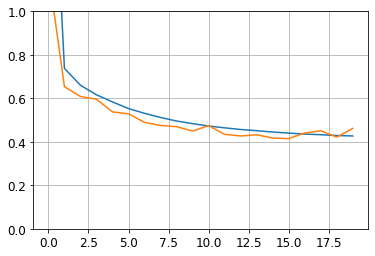

In [68]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [69]:
y_pred

array([[0.6515728],
       [1.7676663],
       [3.504479 ]], dtype=float32)

# Saving and Restoring

Saving a trained Keras model is easy using the Sequential API:

In [70]:
np.random.seed(42)
tf.random.set_seed(42)

In [71]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

In [72]:
model.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=1e-3))

#uSing checkpoint to save model 

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_valid, y_valid), callbacks=[checkpoint_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 2.5311 - val_loss: 2.4690
Epoch 2/10
132/363 [=========>....................] - ETA: 0s - loss: 1.0635

C:\Users\jeromy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


363/363 [==============================] - 1s 1ms/step - loss: 0.9329 - val_loss: 1.8006
Epoch 3/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7081 - val_loss: 0.8965
Epoch 4/10
363/363 [==============================] - 1s 1ms/step - loss: 0.6360 - val_loss: 0.6684
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5974 - val_loss: 0.5519
Epoch 6/10
363/363 [==============================] - 1s 1ms/step - loss: 0.5652 - val_loss: 0.5180
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5385 - val_loss: 0.4931
Epoch 8/10
363/363 [==============================] - 1s 1ms/step - loss: 0.5148 - val_loss: 0.4751
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4945 - val_loss: 0.4581
Epoch 10/10
162/162 [==============================] - 0s 894us/step - loss: 0.4651


In [73]:
model.save("my_keras_model.keras")

In [ ]:
### ENTER CODE HERE ###

In [74]:
model.predict(X_new)

1/1 [==============================] - 0s 70ms/step


array([[0.5771334],
       [1.4511946],
       [3.0918372]], dtype=float32)

In [75]:
model.save_weights("my_keras_weights.ckpt")

In [76]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks During Training

A [callback](https://www.tensorflow.org/guide/keras/custom_callback) is a powerful tool to customize the behavior of a Keras model during training, evaluation, or inference. Examples include `tf.keras.callbacks.TensorBoard` to visualize training progress and results with TensorBoard, or `tf.keras.callbacks.ModelCheckpoint` to periodically save your model during training.



In [77]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
### ENTER CODE HERE ###
### ENTER CODE HERE ###
### ENTER CODE HERE ###
### ENTER CODE HERE ###

In [78]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
### ENTER CODE HERE ###
### ENTER CODE HERE ###
### ENTER CODE HERE ###
### ENTER CODE HERE ###
model = keras.models.load_model("my_keras_model.h5") # rollback to best model

In [79]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 871us/step - loss: 0.4651


In [80]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
### ENTER CODE HERE ###
### ENTER CODE HERE ###
### ENTER CODE HERE ###

In [ ]:
### ENTER CODE HERE ###

In [81]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [82]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

309/363 [========================>.....] - ETA: 0s - loss: 0.4365
val/train: 1.12
363/363 [==============================] - 1s 1ms/step - loss: 0.4336 - val_loss: 0.4876


You can [implement the following callbacks](https://www.tensorflow.org/guide/keras/custom_callback):

- on_train_begin()
- on_train_end()
- on_epoch_begin()
- on_epoch_end()
- on_batch_begin()
- on_batch_end() 

Callbacks can also be used during evaluation and predictions, should you ever need them (i.e. for debugging). For evaluation, you should implement:

- on_test_begin()
- on_test_end()
- on_test_batch_begin()
- or on_test_batch_end()

For prediction you should implement:

- on_predict_begin()
- on_predict_end()
- on_predict_batch_begin()
- on_predict_batch_end()

# Fine-Tuning Neural Network Hyperparameters

The flexibility of neural networks is also one of their main drawbacks: there are many hyperparameters to tweak.  A few examples are:  

- You can build any imaginable network architecture (but, in even a simple MLP you can change the number of layers
- The number of neurons per layer
- The type of activation function to use in each layer 
- The weight initialization logic
- Many more!

In [83]:
import numpy as np
from scikeras.wrappers import KerasRegressor
import randomsear
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [84]:



def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model




Next, let’s create a [KerasRegressor](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasRegressor) based on this `build_model()` function:

In [95]:
keras_reg = KerasRegressor(build_model, learning_rate = 0.001)

Now we can use this object like a regular Scikit-Learn regressor: we can train it using its `fit()` method, then evaluate it using its `score()` method, and use it to make predictions using its `predict()` method, as you can see in the following code:


In [96]:
keras_reg.fit(X_train, y_train, epochs = 100, 
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.8448 - val_loss: 14.5036
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6357 - val_loss: 0.4407
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4548 - val_loss: 0.4012
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4194 - val_loss: 0.4010
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4129 - val_loss: 0.3799
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3980 - val_loss: 0.3835
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3977 - val_loss: 0.3738
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3891 - val_loss: 0.3754
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3818 - val_loss: 0.3703
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3814 - val_l

KerasRegressor(
	model=<function build_model at 0x00000217A973D3F0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	learning_rate=0.001
)

In [97]:
mse_test = keras_reg.score(X_test, y_test)

  1/162 [..............................] - ETA: 7s

162/162 [==============================] - 0s 814us/step


In [98]:
ypred = keras_reg.predict(X_new)
y_pred

1/1 [==============================] - 0s 20ms/step


array([[0.6515728],
       [1.7676663],
       [3.504479 ]], dtype=float32)

In [99]:
np.random.seed(42)
tf.random.set_seed(42)

**Warning**: the following cell crashes at the end of training. This seems to be caused by [Keras issue #13586](https://github.com/keras-team/keras/issues/13586), which was triggered by a recent change in Scikit-Learn. [Pull Request #13598](https://github.com/keras-team/keras/pull/13598) seems to fix the issue, so this problem should be resolved soon.

In [105]:
from sklearn.model_selection import RandomizedSearchCV


# Define your Keras model building function
def build_model(n_neurons=5):
    model = keras.models.Sequential([
        # Add layers with a number of neurons determined by the parameter
        keras.layers.Dense(n_neurons, activation="relu", input_shape=X_train.shape[1:]),
        # Add more layers as needed
        keras.layers.Dense(1)  # Output layer
    ])
    # Compile the model
    model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=0.001))
    return model

# Create an instance of KerasRegressor with your model building function
keras_reg = KerasRegressor(build_fn=build_model, epochs=100)

# Define the parameter distributions for RandomizedSearchCV
param_distribs = {
    # Add other parameters here, if needed
}

# Create an instance of RandomizedSearchCV with the KerasRegressor and parameter distributions
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)

# Fit the RandomizedSearchCV object to your training data
rnd_search_cv.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/100


C:\Users\jeromy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\jeromy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


242/242 [==============================] - 1s 2ms/step - loss: 3.4524 - val_loss: 1.5675
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8770 - val_loss: 0.7383
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6922 - val_loss: 0.6477
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6361 - val_loss: 0.6036
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6022 - val_loss: 0.5726
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5748 - val_loss: 0.5559
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5527 - val_loss: 0.5360
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5367 - val_loss: 0.5154
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5231 - val_loss: 0.4913
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5118 - val_loss: 0.4807
E

C:\Users\jeromy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


242/242 [==============================] - 1s 2ms/step - loss: 2.5226 - val_loss: 15.0198
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.2539 - val_loss: 14.8773
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9396 - val_loss: 10.3580
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7953 - val_loss: 6.6512
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7122 - val_loss: 4.2855
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6584 - val_loss: 2.7074
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6186 - val_loss: 1.7263
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5870 - val_loss: 1.1091
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5617 - val_loss: 0.7647
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5416 - val_loss: 0.590

C:\Users\jeromy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


242/242 [==============================] - 1s 2ms/step - loss: 2.3816 - val_loss: 1.7891
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.5448 - val_loss: 1.1957
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 1.1062 - val_loss: 0.9189
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8981 - val_loss: 0.8030
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8056 - val_loss: 0.7445
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7535 - val_loss: 0.7053
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7156 - val_loss: 0.6731
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6837 - val_loss: 0.6446
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6557 - val_loss: 0.6196
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6311 - val_loss: 0.5967
E

C:\Users\jeromy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


363/363 [==============================] - 1s 1ms/step - loss: 2.4898 - val_loss: 1.6458
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 1.2901 - val_loss: 0.9754
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.8327 - val_loss: 0.7253
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6862 - val_loss: 0.6431
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6314 - val_loss: 0.6003
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5979 - val_loss: 0.5721
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5741 - val_loss: 0.5504
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5554 - val_loss: 0.5329
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5405 - val_loss: 0.5190
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5286 - val_loss: 0.5074
E

RandomizedSearchCV(cv=3,
                   estimator=KerasRegressor(build_fn=<function build_model at 0x00000217AC68E200>, epochs=100),
                   param_distributions={}, verbose=2)

In [106]:
rnd_search_cv.best_params_

{}

In [107]:
rnd_search_cv.best_score_

0.6896207049649815

In [108]:
rnd_search_cv.best_estimator_

KerasRegressor(
	model=None
	build_fn=<function build_model at 0x00000217AC68E200>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
)

In [110]:
model.evaluate(X_test,y_test)

AttributeError: 'NoneType' object has no attribute 'evaluate'

In [109]:
model = rnd_search_cv.best_estimator_.model
model

In [ ]:
### ENTER CODE HERE ###

Here are some Python libraries you can use to optimize hyperparameters:

- __Hyperopt__: A popular library for optimizing over all sorts of complex search spaces (including real values, such as the learning rate, and discrete values, such as the number of layers).


- __Hyperas, kopt, or Talos__: Useful libraries for optimizing hyperparameters for Keras models (the first two are based on Hyperopt).


- __Keras Tuner__: An easy-to-use hyperparameter optimization library by Google for Keras models, with a hosted service for visualization and analysis.


- __Scikit-Optimize (skopt)__: A general-purpose optimization library. The BayesSearchCV class performs Bayesian optimization using an interface similar to GridSearchCV.


- __Spearmint__: A Bayesian optimization library.


- __Hyperband__: A fast hyperparameter tuning library based on the recent Hyperband paper by Lisha Li et al.


- __Sklearn-Deap__: A hyperparameter optimization library based on evolutionary algorithms, with a GridSearchCV-like interface.


A few things to check out:

- [Google Cloud AI Platform’s hyperparameter tuning service](https://cloud.google.com/ai-platform)

- [DeepMind’s excellent 2017 paper](https://arxiv.org/pdf/1711.09846.pdf)

- [Google AutoML suite](https://cloud.google.com/automl)

- [Uber's 2017 Deep Neuroevolution technique](https://eng.uber.com/wp-content/uploads/2017/12/deep-ga-arxiv.pdf)
